# Measurements of Relativistic Corrections

Set up the appropriate paths.

In [1]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import SciFormatter, data_dir, stylesheet

Import the appropriate packages.

In [2]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from nbodykit.cosmology import Planck15

from horizonground.clustering_modification import relativistic_correction_value

plt.style.use(stylesheet)

model = np.random.choice(["PLE_model"])  # "PLE_model", "hybrid_model"
threshold = "-24.0"  # "-22.0", "-25.0"

print("Selected: {}, magnitude limit {}".format(model, threshold))

publication_dir = data_dir/"output"/"publication"/model

Selected: PLE_model, magnitude limit -24.0


## Relativistic correction quantiles

Load samples of the relativistic correction contributions at densly sampled redshifts and determine their quantiles.

In [3]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [4]:
dense_redshifts = []
gz_quantiles = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([
        str(publication_dir), "dense_points", "correction", "relcrct_z*m{}*".format(threshold)
    ]))):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_quantiles[sigma_level].append(gz_q[sigma_level_idx])

In [5]:
dense_redshifts = []
gz_evol_quantiles = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([
        str(publication_dir), "dense_points", "correction", "relcrct_evol_z*m{}*".format(threshold)
    ]))):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_evol_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_evol_quantiles[sigma_level].append(gz_evol_q[sigma_level_idx])

In [6]:
dense_redshifts = []
gz_magn_quantiles = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([
        str(publication_dir), "dense_points", "correction", "relcrct_magn_z*m{}*".format(threshold)
    ]))):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_magn_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_magn_quantiles[sigma_level].append(gz_magn_q[sigma_level_idx])

In [7]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)

if dense_redshifts[discontinuity_pos] == 2.2:
    del dense_redshifts[discontinuity_pos]
    for sigma_level in evolution_bias_quantiles:
        del gz_evol_quantiles[sigma_level][discontinuity_pos]
        del gz_magn_quantiles[sigma_level][discontinuity_pos]

low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

## Relativistic correction measurements

Load samples of the relativistic correction contributions in eBOSS QSO LF redshift bins and determine the estimates with uncertainties.

In [8]:
estimate_levels = [0.158655, 0.5, 0.841345]

In [9]:
measured_redshifts = []
gz_estimates = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([
        str(publication_dir), "eBOSS_binning", "relcrct_z*m{}*".format(threshold)
    ]))):
    measured_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_e = corner.quantile(distilled[:], q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        gz_estimates[sigma_level].append(gz_e[sigma_level_idx])

## Relativistic correction contributions

Compute the background relativistic corrections.

In [10]:
background_corrections = np.asarray([
    relativistic_correction_value(z, cosmo=Planck15) for z in dense_redshifts
])

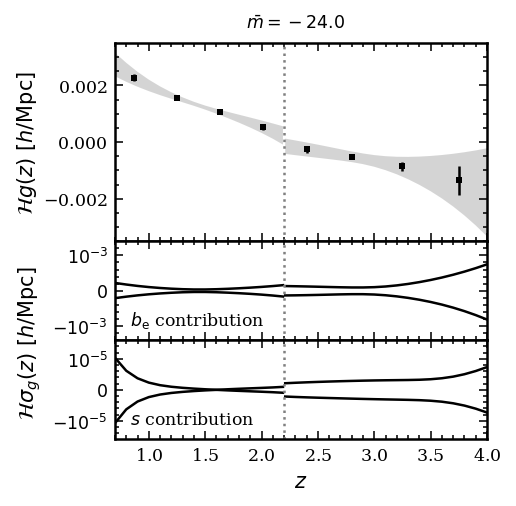

In [11]:
ALPHA = 0.5

fig = plt.figure(
    "relativistic correction contributions", 
    figsize=(3.2, 3.5), dpi=150, constrained_layout=True
)


# Overall corrections
# -------------------

overall = plt.subplot2grid((4, 1), (0, 0), rowspan=2)

overall.errorbar(
    measured_redshifts, np.asarray(gz_estimates[0]),
    yerr=[
        np.asarray(gz_estimates[0]) - np.asarray(gz_estimates[-1]), 
        np.asarray(gz_estimates[1]) - np.asarray(gz_estimates[0])
    ],
    fmt='s'
)

for idx, part in enumerate([low_redshift_part, high_redshift_part]):
    overall.fill_between(
        dense_redshifts[part],
        np.asarray(gz_quantiles[-2])[part], np.asarray(gz_quantiles[2])[part],
        facecolor='0.67', alpha=ALPHA,
    )

overall.axvline(x=2.2, ls=':', c='0.5')

handles, labels = overall.get_legend_handles_labels()

overall.legend(reversed(handles), reversed(labels), handlelength=1.5)
overall.tick_params(axis='x', which='both', labelbottom=False)
overall.set_xticks(np.arange(0., 5., step=0.5))
overall.set_yticks(np.arange(-0.01, 0.01, step=0.002))
overall.xaxis.set_minor_locator(AutoMinorLocator())
overall.yaxis.set_minor_locator(AutoMinorLocator())
overall.set_xlim(min(dense_redshifts), max(dense_redshifts))
overall.set_ylim(-0.0035, 0.0035)
overall.set_ylabel(r"$\mathcal{H} g(z)\ [h/\mathrm{Mpc}]$", labelpad=2)


# Evolution uncertainty contribution
# ----------------------------------

uncertainty_evol = plt.subplot2grid((4, 1), (2, 0), sharex=overall)

for idx, part in enumerate([low_redshift_part, high_redshift_part]):
#     uncertainty_evol.fill_between(
#         dense_redshifts[part], 
#         np.subtract(gz_evol_quantiles[-1], gz_evol_quantiles[0])[part],
#         np.subtract(gz_evol_quantiles[1], gz_evol_quantiles[0])[part],
#         facecolor='0.67', alpha=ALPHA
#     )
    uncertainty_evol.plot(
        dense_redshifts[part], 
        np.subtract(gz_evol_quantiles[-1], gz_evol_quantiles[0])[part],
        c='k', ls='-'
    )
    uncertainty_evol.plot(
        dense_redshifts[part], 
        np.subtract(gz_evol_quantiles[1], gz_evol_quantiles[0])[part],
        c='k', ls='-'
    )
    
uncertainty_evol.axvline(x=2.2, ls=':', c='0.5')

uncertainty_evol.set_title(
    r'$b_\mathrm{e}$ contribution', loc='left', position=(0.04, 0.025), fontsize='small'
)
uncertainty_evol.tick_params(axis='x', which='both', labelbottom=False)
uncertainty_evol.set_yticks(np.arange(-2.e-3, 2.e-3, step=1.e-3))
uncertainty_evol.yaxis.set_major_formatter(SciFormatter("%1.0e"))
uncertainty_evol.yaxis.set_minor_locator(AutoMinorLocator())
uncertainty_evol.set_ylim(-1.4e-3, 1.4e-3)


# Magnification uncertainty contribution
# --------------------------------------

uncertainty_magn = plt.subplot2grid((4, 1), (3, 0), sharex=overall)

for idx, part in enumerate([low_redshift_part, high_redshift_part]):
#     uncertainty_magn.fill_between(
#         dense_redshifts[part],
#         np.subtract(gz_magn_quantiles[-1], gz_magn_quantiles[0])[part],
#         np.subtract(gz_magn_quantiles[1], gz_magn_quantiles[0])[part],
#         facecolor='0.67', alpha=ALPHA
#     )
    uncertainty_magn.plot(
        dense_redshifts[part], 
        np.subtract(gz_magn_quantiles[-1], gz_magn_quantiles[0])[part],
        c='k', ls='-'
    )
    uncertainty_magn.plot(
        dense_redshifts[part], 
        np.subtract(gz_magn_quantiles[1], gz_magn_quantiles[0])[part],
        c='k', ls='-'
    )

uncertainty_magn.axvline(x=2.2, ls=':', c='0.5')

uncertainty_magn.set_title(
    r'$s$ contribution', loc='left', position=(0.04, 0.025), fontsize='small'
)
uncertainty_magn.set_yticks(np.arange(-2.e-5, 2.e-5, step=1.e-5))
uncertainty_magn.yaxis.set_major_formatter(SciFormatter("%1.0e"))
uncertainty_magn.yaxis.set_minor_locator(AutoMinorLocator())
uncertainty_magn.set_ylim(-1.6e-5, 1.6e-5)
uncertainty_magn.set_xlabel(r"$z$")

fig.text(
    -0.0525, 0.31, r"$\mathcal{H} \sigma_g(z)\ [h/\mathrm{Mpc}]$", 
    ha='center', va='center', rotation='vertical'
)
fig.suptitle(r"$\bar{{m}} = {}$".format(threshold), fontsize='small', y=0.935)
fig.savefig(
    publication_dir/"gallery"/"relativistic_correction_breakdown_m{}.pdf".format(threshold)
)